In [192]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [193]:
RANDOM_STATE = 42

Downloading dataset: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

In [194]:
import os
import gdown

if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [195]:
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Pre-processing

In [196]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


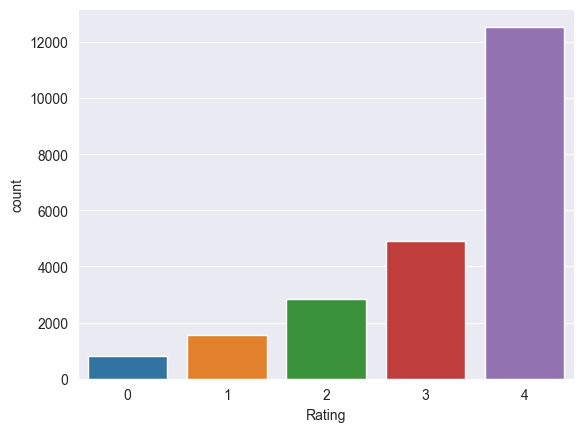

In [197]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [198]:
X = df_reviews['Review Text'].values.reshape(-1, 1)
y = df_reviews['Rating']

In [199]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=RANDOM_STATE)
X_res, y_res = undersample.fit_resample(X, y)

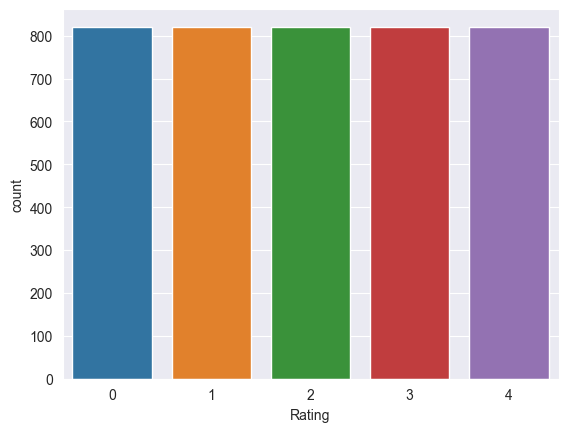

In [200]:
sns.countplot(x='Rating', data=y_res.to_frame())
plt.show()

In [201]:
reviews_array = X_res.ravel()

In [202]:
reviews_array[0:5]

array(["3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very itchy so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such itchy tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and flimsy that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!",
       'I was really hoping to like this, but it did not look the way it does on the model, at least not on me. the sharkbite hem is much more pronounced and looser. the one in the photo looks like it was pinned back. i am 5\'8" and usually wear a medium or large. i got a medium and there was a lot more material on the bottom half than the photo shows. it made me look bigger and was not flattering. material has a nice weave but it\'s thin and delicate. i bought the (holly) deep olive and the blue. co

In [203]:
len(reviews_array)

4105

In [204]:
type(reviews_array)

numpy.ndarray

In [205]:
import re
import unicodedata
from keras.src.preprocessing.text import text_to_word_sequence

pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
sentence_tokens = []
for sentence in reviews_array:
    ttw = text_to_word_sequence(sentence)
    ttw_processed = []
    for word in ttw:
        word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        word = re.sub(pattern, '', word)
        ttw_processed.append(word)
    sentence_tokens.append(ttw_processed)

In [206]:
sentence_tokens[0:2]

[['3',
  'tags',
  'sewn',
  'in',
  '2',
  'small',
  'about',
  "1''",
  'long',
  'and',
  '1',
  'huge',
  'about',
  "2''",
  'x',
  "3''",
  'very',
  'itchy',
  'so',
  'i',
  'cut',
  'them',
  'out',
  'then',
  'the',
  'thread',
  'left',
  'behind',
  'was',
  'plasticy',
  'and',
  'even',
  'more',
  'itchy',
  'how',
  'can',
  'you',
  'make',
  'an',
  'intimates',
  'item',
  'with',
  'such',
  'itchy',
  'tags',
  'not',
  'comfortable',
  'at',
  'all',
  'also',
  'i',
  'love',
  'bralettes',
  'and',
  'wear',
  'them',
  'all',
  'the',
  'time',
  'including',
  'to',
  'work',
  'i',
  'am',
  'a',
  'b',
  'cup',
  'however',
  'this',
  'one',
  'is',
  'so',
  'thin',
  'and',
  'flimsy',
  'that',
  'it',
  'gives',
  'no',
  'support',
  'even',
  'to',
  'a',
  'b',
  'cup',
  'so',
  'for',
  'me',
  'this',
  'would',
  'only',
  'be',
  'a',
  'lounging',
  'bralette',
  'if',
  'it',
  "wasn't",
  'so',
  'itchy'],
 ['i',
  'was',
  'really',
  'hop

In [207]:
distinct_tokens = []
for sentence in sentence_tokens:
    for token in sentence:
        if token not in distinct_tokens:
            distinct_tokens.append(token)

In [208]:
len(distinct_tokens)

7268

In [209]:
from keras.preprocessing.text import Tokenizer

num_words = 2000
vocab_size = distinct_tokens

tok = Tokenizer(num_words)
tok.fit_on_texts(sentence_tokens)
sequences = tok.texts_to_sequences(sentence_tokens)

In [210]:
sequences[:20]

[[376,
  1597,
  564,
  9,
  173,
  42,
  107,
  99,
  3,
  444,
  183,
  107,
  1033,
  22,
  466,
  16,
  2,
  113,
  78,
  54,
  221,
  1,
  772,
  725,
  1068,
  11,
  3,
  77,
  55,
  466,
  164,
  103,
  38,
  198,
  56,
  445,
  18,
  324,
  466,
  1597,
  15,
  129,
  40,
  63,
  66,
  2,
  31,
  3,
  39,
  78,
  63,
  1,
  180,
  1515,
  8,
  112,
  2,
  41,
  5,
  630,
  678,
  94,
  7,
  58,
  6,
  16,
  138,
  3,
  813,
  20,
  4,
  799,
  105,
  1069,
  77,
  8,
  5,
  630,
  678,
  16,
  14,
  25,
  7,
  34,
  122,
  29,
  5,
  1516,
  45,
  4,
  227,
  16,
  466],
 [2,
  11,
  50,
  402,
  8,
  21,
  7,
  10,
  4,
  117,
  15,
  47,
  1,
  73,
  4,
  153,
  12,
  1,
  131,
  40,
  368,
  15,
  12,
  25,
  1,
  375,
  6,
  64,
  55,
  3,
  840,
  1,
  58,
  9,
  1,
  239,
  67,
  21,
  4,
  11,
  1298,
  49,
  2,
  41,
  551,
  3,
  121,
  39,
  5,
  123,
  44,
  72,
  2,
  118,
  5,
  123,
  3,
  87,
  11,
  5,
  234,
  55,
  59,
  12,
  1,
  149,
  565,
  65,
  1,
  239

In [211]:
print(tok.word_index)

{'the': 1, 'i': 2, 'and': 3, 'it': 4, 'a': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'was': 11, 'on': 12, 'of': 13, 'for': 14, 'not': 15, 'so': 16, 'dress': 17, 'with': 18, 'my': 19, 'that': 20, 'like': 21, 'very': 22, 'have': 23, 'top': 24, 'me': 25, 'size': 26, 'too': 27, 'fit': 28, 'be': 29, 'are': 30, 'love': 31, 'as': 32, 'just': 33, 'would': 34, 'fabric': 35, "it's": 36, "i'm": 37, 'you': 38, 'wear': 39, 'at': 40, 'am': 41, 'small': 42, 'they': 43, 'or': 44, 'if': 45, 'up': 46, 'look': 47, 'great': 48, 'back': 49, 'really': 50, 'ordered': 51, 'color': 52, 'had': 53, 'out': 54, 'more': 55, 'an': 56, 'when': 57, 'one': 58, 'material': 59, 'because': 60, 'shirt': 61, '\r': 62, 'all': 63, 'much': 64, 'than': 65, 'also': 66, 'looks': 67, 'little': 68, 'will': 69, 'these': 70, 'cute': 71, 'large': 72, 'way': 73, 'quality': 74, 'well': 75, 'nice': 76, 'even': 77, 'them': 78, 'flattering': 79, 'down': 80, 'which': 81, 'were': 82, 'made': 83, 'beautiful': 84, 'sweater': 85, 'wai

In [212]:
sentence_tokens_as_numbers = []

for sentence in sentence_tokens:
    sentence_as_num = []
    for token in sentence:
        sentence_as_num.append(tok.word_index[token])
    sentence_tokens_as_numbers.append(sentence_as_num)

In [213]:
len(max(sentence_tokens_as_numbers, key=len))

114

In [214]:
max_length_sentence_index = sentence_tokens_as_numbers.index(max(sentence_tokens_as_numbers, key=len))
max_length_sentence_index

1836

In [215]:
sentence_tokens[max_length_sentence_index]

['i',
 'got',
 'a',
 'medium',
 'as',
 'i',
 'usually',
 'wear',
 'that',
 'in',
 'everything',
 'i',
 'am',
 'a',
 '36d',
 'and',
 'this',
 'pulled',
 'a',
 'bit',
 'across',
 'my',
 'chest',
 'and',
 'back',
 'it',
 'is',
 'a',
 'cute',
 'idea',
 'but',
 'the',
 'fit',
 'is',
 'off',
 'for',
 'my',
 'body',
 'i',
 'am',
 "5'6",
 'and',
 'hits',
 'me',
 'shorter',
 'than',
 'shown',
 'on',
 'the',
 'model',
 'so',
 'hits',
 'at',
 'an',
 'odd',
 'length',
 'i',
 'may',
 'try',
 'to',
 'order',
 'a',
 'large',
 'and',
 'see',
 'if',
 'it',
 'is',
 'better',
 'on',
 'me',
 'because',
 'i',
 'am',
 'so',
 'hopeful',
 'for',
 'this',
 'to',
 'look',
 'cute',
 'on',
 'me',
 'the',
 'teal',
 'blue',
 'color',
 'is',
 'beautiful',
 'the',
 'pink',
 'is',
 'more',
 'a',
 'blush',
 'and',
 'washed',
 'me',
 'out',
 'the',
 'grey',
 'is',
 'just',
 'grey',
 'i',
 'bought',
 'three',
 'thinking',
 'this',
 'would',
 'be',
 'my',
 'go',
 't']

In [216]:
len(sentence_tokens[max_length_sentence_index])

114

In [217]:
from tensorflow.keras.utils import pad_sequences
maxlen = len(sentence_tokens[max_length_sentence_index])

X_pad = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [218]:
X = X_pad
y = pd.get_dummies(y_res, columns = ['Remarks', 'Gender'])

In [219]:
X.shape

(4105, 114)

In [220]:
y.shape

(4105, 5)

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=RANDOM_STATE)

In [222]:
in_shape = X_train.shape[1]
out_shape = 5
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 114 , out_shape 5


Training without pre-trained embeddings

In [237]:
from keras.layers import LSTM, Embedding, Dropout, Bidirectional

embedding_vector_features=50
model=Sequential()
model.add(Embedding(len(distinct_tokens),embedding_vector_features,input_length=in_shape))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.33))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 114, 50)           363400    
                                                                 
 dropout_55 (Dropout)        (None, 114, 50)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 114, 200)          120800    
 onal)                                                           
                                                                 
 dropout_56 (Dropout)        (None, 114, 200)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dropout_57 (Dropout)        (None, 200)             

In [232]:
from keras.layers import LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(input_dim=len(distinct_tokens), output_dim=32, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=64))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
# model.add(Dense(units=512, activation='relu'))
# model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 114, 32)           232576    
                                                                 
 lstm_47 (LSTM)              (None, 114, 64)           24832     
                                                                 
 dropout_50 (Dropout)        (None, 114, 64)           0         
                                                                 
 lstm_48 (LSTM)              (None, 64)                33024     
                                                                 
 dense_47 (Dense)            (None, 128)               8320      
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 5)               

In [238]:
hist = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
83/83 [==============================] - 34s 354ms/step - loss: 1.5869 - accuracy: 0.2425 - val_loss: 1.3870 - val_accuracy: 0.3592
Epoch 2/10
83/83 [==============================] - 23s 280ms/step - loss: 1.3345 - accuracy: 0.3848 - val_loss: 1.3665 - val_accuracy: 0.3760
Epoch 3/10
83/83 [==============================] - 20s 245ms/step - loss: 1.1989 - accuracy: 0.4427 - val_loss: 1.2736 - val_accuracy: 0.3988
Epoch 4/10
83/83 [==============================] - 20s 246ms/step - loss: 1.0723 - accuracy: 0.5253 - val_loss: 1.3790 - val_accuracy: 0.4049
Epoch 5/10
83/83 [==============================] - 20s 246ms/step - loss: 0.9771 - accuracy: 0.5691 - val_loss: 1.3854 - val_accuracy: 0.4170
Epoch 6/10
83/83 [==============================] - 20s 246ms/step - loss: 0.8725 - accuracy: 0.6277 - val_loss: 1.4433 - val_accuracy: 0.4125
Epoch 7/10
83/83 [==============================] - 20s 246ms/step - loss: 0.7914 - accuracy: 0.6608 - val_loss: 1.5811 - val_accuracy: 0.4155

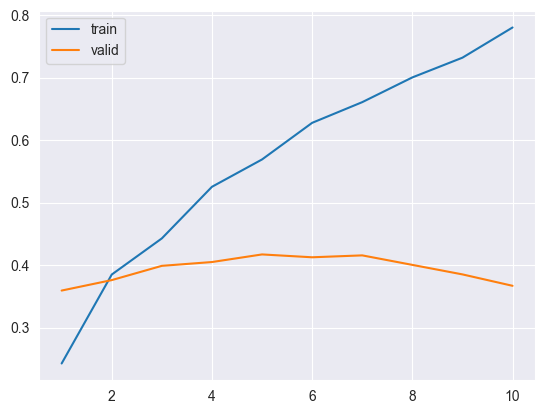

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [226]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 12ms/step - loss: 0.5545 - accuracy: 0.4032


[0.5545433759689331, 0.40316686034202576]